# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

0.34949845020057657
2.7885577115423086 0.3457471656304173
2.7925585117023406 0.34199034689954394
2.7965593118623726 0.3382280541410268
2.8005601120224046 0.3344603475755556
2.8045609121824366 0.3306872875104755
2.8085617123424687 0.3269089343388218
2.8125625125025007 0.3231253485383533
2.8165633126625327 0.31933659067058423
2.8205641128225647 0.3155427213798149
2.8245649129825967 0.3117438013921611
2.8285657131426287 0.3079398915145818
2.8325665133026607 0.3041310526339062
2.8365673134626928 0.300317345715859
2.8405681136227248 0.29649883180408443
2.844568913782757 0.2926755720191694
2.8485697139427884 0.28884762755766547
2.8525705141028204 0.2850150596911077
2.8565713142628524 0.28117792976503625
2.8605721144228844 0.27733629919801306
2.8645729145829164 0.273490229480639
2.8685737147429484 0.2696397821745697
2.8725745149029804 0.26578501891153006
2.8765753150630125 0.2619260013923279
2.8805761152230445 0.25806279138586624
2.8845769153830765 0.25419545072815464
2.8885777155431085 0.250


5.521104220844169 -0.6904283985076866
5.525105021004201 -0.687528698813709
5.529105821164233 -0.6846179942737255
5.533106621324265 -0.6816963314775805
5.537107421484297 -0.6787637571905205
5.541108221644329 -0.6758203183524457
5.545109021804361 -0.6728660620771585
5.549109821964393 -0.6699010356516089
5.553110622124425 -0.6669252865351383
5.557111422284457 -0.6639388623587196
5.561112222444489 -0.6609418109241947
5.565113022604521 -0.6579341802035094
5.569113822764553 -0.6549160183379458
5.573114622924585 -0.651887373637351
5.577115423084617 -0.6488482945793651
5.581116223244649 -0.6457988298086439
5.585117023404681 -0.642739028136081
5.589117823564713 -0.6396689385380264
5.593118623724745 -0.6365886101555028
5.597119423884777 -0.6334980922934185
5.601120224044809 -0.6303974344197784
5.605121024204841 -0.6272866861648925
5.609121824364873 -0.6241658973205814
5.613122624524905 -0.6210351178393788
5.617123424684937 -0.6178943978337327
5.621124224844969 -0.6147437875752028
5.625125025005

0.7998699029164902
8.501700340068014 0.7974623338819133
8.505701140228046 0.79504200036173
8.509701940388078 0.7926089410967198
8.51370274054811 0.7901631950313549
8.517703540708142 0.787704801313178
8.521704340868174 0.7852337992921743
8.525705141028206 0.7827502285201425
8.529705941188238 0.7802541287500618
8.53370674134827 0.777745539935455
8.537707541508302 0.7752245022297491
8.541708341668334 0.7726910559856334
8.545709141828366 0.7701452417544123
8.549709941988398 0.7675871002853576
8.55371074214843 0.7650166725250549
8.557711542308462 0.7624339996167493
8.561712342468494 0.7598391228996862
8.565713142628526 0.7572320839084501
8.569713942788558 0.7546129243722989
8.57371474294859 0.751981686214497
8.577715543108622 0.7493384115516439
8.581716343268655 0.7466831426929997
8.585717143428687 0.7440159221398083
8.589717943588719 0.7413367925846168
8.59371874374875 0.7386457969105926
8.597719543908783 0.7359429781908365
8.601720344068815 0.7332283796876937
8.605721144228847 0.730502044

-0.9568940368707535
11.294258851770355 -0.9557244003278498
11.298259651930387 -0.9545394660964744
11.302260452090419 -0.9533392531431355
11.30626125225045 -0.9521237806788982
11.310262052410483 -0.9508930681590777
11.314262852570515 -0.9496471352829267
11.318263652730547 -0.9483860019933209
11.322264452890579 -0.94710968847644
11.326265253050611 -0.9458182151614436
11.330266053210643 -0.9445116027201452
11.334266853370675 -0.9431898720666808
11.338267653530707 -0.9418530443571742
11.342268453690739 -0.9405011409893985
11.346269253850771 -0.9391341836024335
11.350270054010803 -0.9377521940763194
11.354270854170835 -0.9363551945317065
11.358271654330867 -0.934943207329501
11.362272454490899 -0.9335162550705075
11.366273254650931 -0.9320743605950671
11.370274054810963 -0.9306175469826913
11.374274854970995 -0.9291458375516932
11.378275655131027 -0.9276592558588141
11.382276455291057 -0.9261578256988472
11.38627725545109 -0.9246415711042534
11.390278055611121 -0.9231105163447815
11.3942788

0.984133284301308
13.962792558511703 0.984835271261273
13.966793358671735 0.9855214945730874
13.970794158831767 0.9861919432527995
13.974794958991799 0.9868466065689528
13.978795759151831 0.987485474042757
13.982796559311863 0.9881085354482563
13.986797359471895 0.9887157808124926
13.990798159631927 0.9893072004156654
13.994798959791959 0.9898827847912878
13.998799759951991 0.9904425247263369
14.002800560112023 0.9909864112614024
14.006801360272055 0.9915144356908295
14.010802160432087 0.9920265895628582
14.01480296059212 0.9925228646797586
14.018803760752151 0.9930032530979624
14.022804560912183 0.9934677471281897
14.026805361072215 0.9939163393355724
14.030806161232247 0.994349022539773
14.03480696139228 0.9947657898150991
14.038807761552311 0.9951666344906154
14.042808561712343 0.9955515501502492
14.046809361872375 0.9959205306328942
14.050810162032407 0.9962735700325084
14.05481096219244 0.9966106626982086
14.058811762352471 0.9969318032343615
14.062812562512503 0.9972369865006693


-0.8759452634916054
16.779355871174236 -0.8778682760119247
16.783356671334268 -0.8797772370385278
16.7873574714943 -0.8816721160158578
16.79135827165433 -0.883552882613761
16.795359071814364 -0.8854195067279711
16.799359871974396 -0.8872719584805923
16.803360672134428 -0.8891102082205768
16.80736147229446 -0.8909342265242
16.81136227245449 -0.8927439841955302
16.815363072614524 -0.8945394522668979
16.819363872774556 -0.8963206019993576
16.823364672934588 -0.8980874048831489
16.82736547309462 -0.8998398326381523
16.831366273254652 -0.9015778572143424
16.835367073414684 -0.9033014507922363
16.839367873574716 -0.9050105857833394
16.843368673734748 -0.9067052348305864
16.84736947389478 -0.9083853708087798
16.851370274054812 -0.9100509668250236
16.855371074214844 -0.9117019962191544
16.859371874374876 -0.913338432564167
16.863372674534908 -0.9149602496666387
16.86737347469494 -0.9165674215671478
16.871374274854972 -0.918159922540689
16.875375075015004 -0.9197377270970859
16.879375875175036 

19.835967193438687 0.8340515005355742
19.83996799359872 0.8362520073752322
19.84396879375875 0.8384391288470077
19.847969593918783 0.8406128299430019
19.851970394078815 0.842773075870128
19.855971194238847 0.8449198320506673
19.85997199439888 0.8470530641228237
19.86397279455891 0.8491727379412726
19.867973594718944 0.8512788195777083
19.871974394878976 0.8533712753213866
19.875975195039008 0.8554500716796644
19.87997599519904 0.8575151753785362
19.88397679535907 0.8595665533631662
19.887977595519104 0.8616041727984178
19.891978395679136 0.8636280010693788
19.895979195839168 0.8656380057818835
19.8999799959992 0.867634154763032
19.90398079615923 0.8696164160617035
19.907981596319264 0.8715847579490695
19.911982396479296 0.8735391489191008
19.915983196639328 0.8754795576890715
19.91998399679936 0.8774059532000605
19.92398479695939 0.8793183046174481
19.927985597119424 0.8812165813314098
19.931986397279456 0.8831007529574059
19.935987197439488 0.8849707893366684
19.93998799759952 0.88682

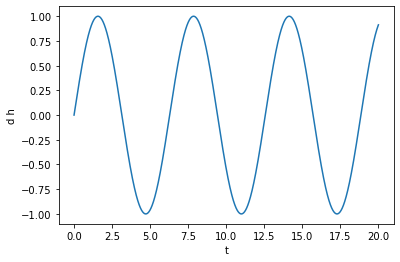

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

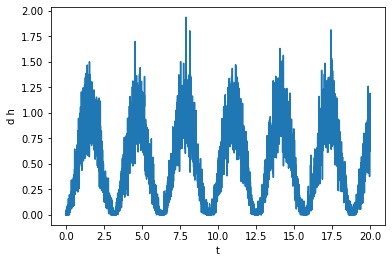

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

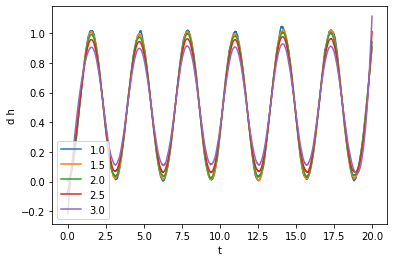

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

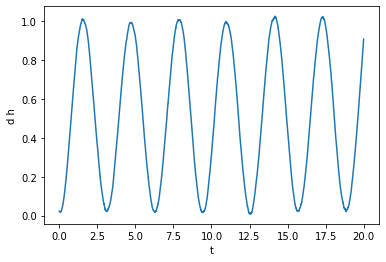

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1940


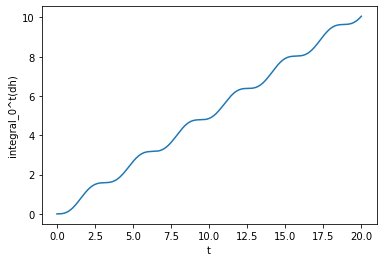

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

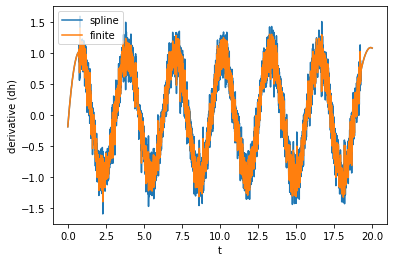

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

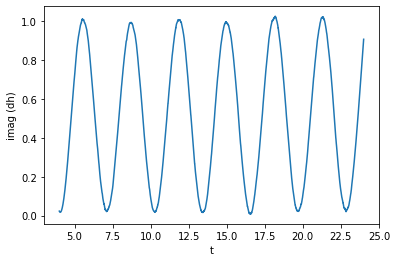

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

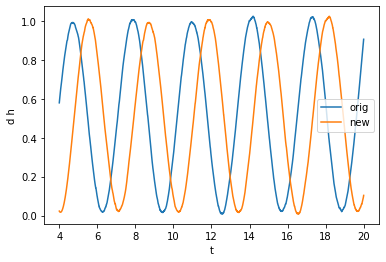

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

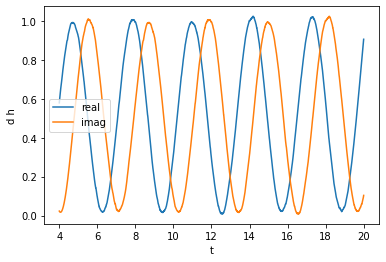

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

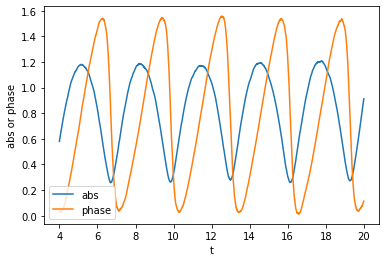

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

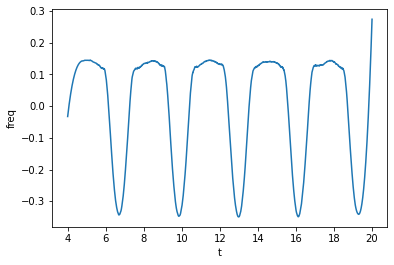

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

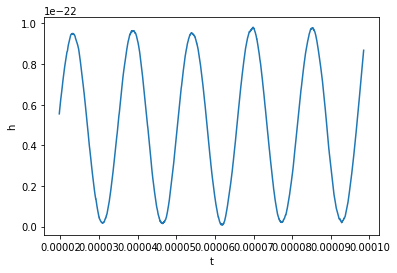

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

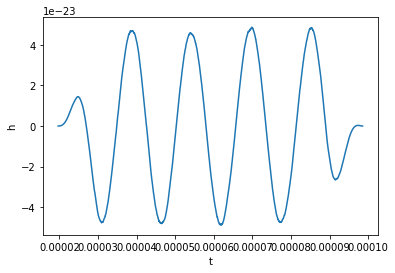

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

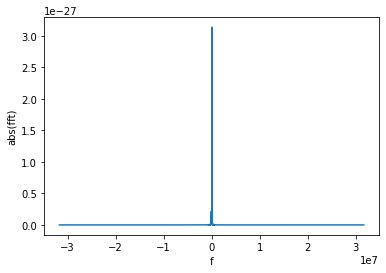

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

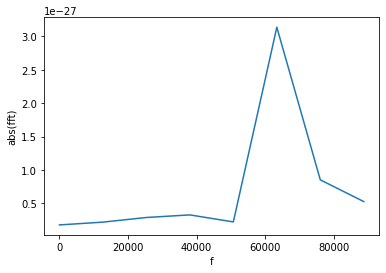

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64200.39


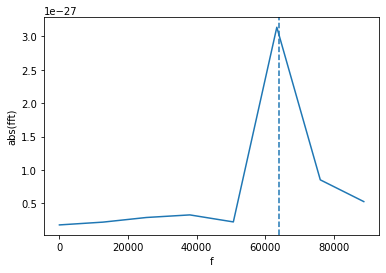

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.138e-27
Maximum with mask 8.510e-28
Length with mask 8
Length after having removed the masked points 7
